In [1]:
# Import packages and connect to database
import sqlite3
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle

%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

In [ ]:
### Data Cleaning

In [2]:
with open('More_Than_1Acre.pickle','rb') as read_file:
    fires = pickle.load(read_file)

In [3]:
fires.to_csv('firedata.csv')

In [4]:
fires['FIRE_SIZE_CLASS'].value_counts()

B    472539
C    220077
D     28427
E     14107
F      7786
G      3773
Name: FIRE_SIZE_CLASS, dtype: int64

In [5]:
fires['FIRE_SIZE_CLASS_BIN'] = np.where(fires['FIRE_SIZE_CLASS'].isin(['B']), 0, 1)

In [6]:
# NOAA climate regions
fires['REGION'] = np.where(fires['STATE'].isin(['WA', 'OR', 'ID']), 'Northwest', 
                  np.where(fires['STATE'].isin(['CA', 'NV']), 'West', 
                  np.where(fires['STATE'].isin(['MT', 'NE', 'ND', 'SD', 'WY']), 'Northern Rockies', 
                  np.where(fires['STATE'].isin(['AK', 'HI']), 'Alaska_Hawaii', 
                  np.where(fires['STATE'].isin(['AZ', 'NM', 'CO', 'UT']), 'Southwest',          
                  np.where(fires['STATE'].isin(['OK', 'TX', 'KS', 'AR', 'LA', 'MS']), 'South', 
                  np.where(fires['STATE'].isin(['AL', 'FL', 'GA', 'NC', 'SC', 'VA']), 'Southeast', 
                  np.where(fires['STATE'].isin(['IL', 'IN', 'KY', 'MO', 'TN', 'OH', 'WV']), 'Ohio Valley', 
                  np.where(fires['STATE'].isin(['IA',  'MI', 'MN', 'WI']), 'Upper Midwest', 
                  np.where(fires['STATE'].isin(['CT', 'NY', 'ME', 'MA', 'MD', 'NH', 'NJ', 'PA', 'RI', 'VT', 'DE']), 'Northeast', 'None'        
                                  ))))))))))

In [7]:
fires['REGION'].value_counts()

Southeast           254930
South               207321
Ohio Valley          64018
West                 44582
Southwest            39742
Northern Rockies     35196
Upper Midwest        29912
Northeast            29189
Northwest            26079
None                 10192
Alaska_Hawaii         5548
Name: REGION, dtype: int64

In [8]:
# Creating new date variables
fires['DAYS_TO_CONTAIN'] = fires['CONT_DATE'] - fires['DISCOVERY_DATE'] 
fires['DAYS_TO_CONTAIN'] = fires['DAYS_TO_CONTAIN'].fillna(0)
fires['DISCOVERY_DATE_DT'] = pd.to_datetime(fires['DISCOVERY_DATE'], unit='D', origin='julian')
fires['CONT_DATE_DT'] = pd.to_datetime(fires['CONT_DATE'], unit='D', origin='julian')

In [69]:
combined_df.corr()

OBJECTID    FOD_ID  FIRE_YEAR  \
OBJECTID                            1.000000  0.733259   0.477891   
FOD_ID                              0.733259  1.000000   0.674608   
FIRE_YEAR                           0.477891  0.674608   1.000000   
DISCOVERY_DATE                      0.475426  0.673249   0.999218   
DISCOVERY_DOY                      -0.053619 -0.021916  -0.001496   
STAT_CAUSE_CODE                     0.087201  0.036191  -0.006610   
CONT_DATE                           0.603812  0.755777   0.999436   
CONT_DOY                           -0.109595 -0.035071   0.022673   
FIRE_SIZE                          -0.019822  0.007092   0.013530   
LATITUDE                           -0.169328 -0.060076   0.011583   
LONGITUDE                           0.201895 -0.022275  -0.011569   
OWNER_CODE                          0.108698 -0.145797  -0.094246   
FIRE_SIZE_CLASS_BIN                -0.052913  0.009083   0.023924   
DAYS_TO_CONTAIN                    -0.024416  0.032252   0.040084   
STAT_CAUSE_DESCR_Campfire           0.015098  0.020333   0.011350   
STAT_CAUSE_DESCR_Children          -0.017695 -0.025815  -0.036531   
STAT_CAUSE_DESCR_Debris Burning     0.093839  0.033013   0.038208   
STAT_CAUSE_DESCR_Equipment Use      0.021850  0.005470   0.010487   
STAT_CAUSE_DESCR_Fireworks          0.001491  0.011043   0.014358   
STAT_CAUSE_DESCR_Lightning         -0.157543 -0.004026   0.023956   
STAT_CAUSE_DESCR_Miscellaneous      0.042798  0.052313   0.088844   
STAT_CAUSE_DESCR_Missing/Undefined  0.032360  0.038768  -0.027952   
STAT_CAUSE_DESCR_Powerline          0.061490  0.087818   0.073277   
STAT_CAUSE_DESCR_Railroad          -0.003703 -0.048941  -0.086910   
STAT_CAUSE_DESCR_Smoking           -0.006563 -0.022822  -0.039373   
STAT_CAUSE_DESCR_Structure          0.025561  0.027432   0.027610   
REGION_None                         0.173621  0.181933   0.053410   
REGION_Northeast                    0.107908  0.009079   0.066019   
REGION_Northern Rockies            -0.108506  0.018242   0.032588   
REGION_Northwest                   -0.110791  0.000081  -0.001217   
REGION_Ohio Valley                  0.056279 -0.008948   0.022697   
REGION_South                        0.014154  0.074363   0.112599   
REGION_Southeast                    0.075448 -0.098306  -0.123704   
REGION_Southwest                   -0.180797 -0.049214  -0.063219   
REGION_Upper Midwest               -0.052612 -0.009645  -0.008473   
REGION_West                        -0.019815 -0.009659  -0.038239   

                                    DISCOVERY_DATE  DISCOVERY_DOY  \
OBJECTID                                  0.475426      -0.053619   
FOD_ID                                    0.673249      -0.021916   
FIRE_YEAR                                 0.999218      -0.001496   
DISCOVERY_DATE                            1.000000       0.038041   
DISCOVERY_DOY                             0.038041       1.000000   
STAT_CAUSE_CODE                          -0.010955      -0.110028   
CONT_DATE                                 0.999988       0.049917   
CONT_DOY                                  0.055434       0.993131   
FIRE_SIZE                                 0.014115       0.015077   
LATITUDE                                  0.016165       0.116144   
LONGITUDE                                -0.020265      -0.220222   
OWNER_CODE                               -0.098110      -0.099472   
FIRE_SIZE_CLASS_BIN                       0.024174       0.006806   
DAYS_TO_CONTAIN                           0.041321       0.032032   
STAT_CAUSE_DESCR_Campfire                 0.011653       0.007875   
STAT_CAUSE_DESCR_Children                -0.037012      -0.012814   
STAT_CAUSE_DESCR_Debris Burning           0.034062      -0.104186   
STAT_CAUSE_DESCR_Equipment Use            0.012810       0.058975   
STAT_CAUSE_DESCR_Fireworks                0.015271       0.023327   
STAT_CAUSE_DESCR_Lightning                0.030218       0.158859   
STAT_CAUSE_DESCR_Miscellaneous   

In [61]:
fires.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 746709 entries, 13 to 1880463
Data columns (total 34 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   OBJECTID                    746709 non-null  int64         
 1   FOD_ID                      746709 non-null  int64         
 2   FPA_ID                      746709 non-null  object        
 3   SOURCE_SYSTEM_TYPE          746709 non-null  object        
 4   SOURCE_SYSTEM               746709 non-null  object        
 5   NWCG_REPORTING_AGENCY       746709 non-null  object        
 6   NWCG_REPORTING_UNIT_ID      746709 non-null  object        
 7   NWCG_REPORTING_UNIT_NAME    746709 non-null  object        
 8   SOURCE_REPORTING_UNIT       746709 non-null  object        
 9   SOURCE_REPORTING_UNIT_NAME  746709 non-null  object        
 10  LOCAL_FIRE_REPORT_ID        118376 non-null  object        
 11  FIRE_NAME                   305330 no

In [9]:
from sklearn.model_selection import train_test_split

fires_train, fires_test = train_test_split(fires, test_size=0.2, random_state=42)

In [9]:
data_crosstab = pd.crosstab(fires_train['STAT_CAUSE_DESCR'], 
                            fires_train['FIRE_SIZE_CLASS_BIN'],  
                               margins = False, normalize = 'index') 
print(data_crosstab) 

FIRE_SIZE_CLASS_BIN         0         1
STAT_CAUSE_DESCR                       
Arson                0.572871  0.427129
Campfire             0.684866  0.315134
Children             0.811753  0.188247
Debris Burning       0.703270  0.296730
Equipment Use        0.625239  0.374761
Fireworks            0.582977  0.417023
Lightning            0.499076  0.500924
Miscellaneous        0.649920  0.350080
Missing/Undefined    0.612341  0.387659
Powerline            0.555556  0.444444
Railroad             0.663299  0.336701
Smoking              0.738477  0.261523
Structure            0.707533  0.292467


In [ ]:
# Box and whisker plot of fire size by cause 

In [10]:
data_crosstab = pd.crosstab(fires_train['REGION'], 
                            fires_train['FIRE_SIZE_CLASS_BIN'],  
                               margins = False, normalize = 'index') 
print(data_crosstab) 

FIRE_SIZE_CLASS_BIN         0         1
REGION                                 
Alaska_Hawaii        0.390660  0.609340
None                 0.726179  0.273821
Northeast            0.902126  0.097874
Northern Rockies     0.538987  0.461013
Northwest            0.537150  0.462850
Ohio Valley          0.540800  0.459200
South                0.572376  0.427624
Southeast            0.707106  0.292894
Southwest            0.554888  0.445112
Upper Midwest        0.695104  0.304896
West                 0.609787  0.390213


In [ ]:
# Box and whisker plot of fire size by region

In [14]:
#plt.scatter(data=fires_train, x='DAYS_TO_CONTAIN', y='FIRE_SIZE', marker='o', s=25);


In [10]:
combined_df = pd.get_dummies(fires_train, columns = ['STAT_CAUSE_DESCR', 'REGION'], drop_first = True)
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 597367 entries, 1071751 to 413409
Data columns (total 54 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   OBJECTID                            597367 non-null  int64         
 1   FOD_ID                              597367 non-null  int64         
 2   FPA_ID                              597367 non-null  object        
 3   SOURCE_SYSTEM_TYPE                  597367 non-null  object        
 4   SOURCE_SYSTEM                       597367 non-null  object        
 5   NWCG_REPORTING_AGENCY               597367 non-null  object        
 6   NWCG_REPORTING_UNIT_ID              597367 non-null  object        
 7   NWCG_REPORTING_UNIT_NAME            597367 non-null  object        
 8   SOURCE_REPORTING_UNIT               597367 non-null  object        
 9   SOURCE_REPORTING_UNIT_NAME          597367 non-null  object        
 10  LO

### Logistic Regression

In [36]:
# Since we're using more than one feature, let's scale our features
scaler = StandardScaler()
X_train = scaler.fit_transform(combined_df[['STAT_CAUSE_DESCR_Campfire', 
                    'STAT_CAUSE_DESCR_Children', 'STAT_CAUSE_DESCR_Debris Burning',
                     'STAT_CAUSE_DESCR_Equipment Use', 'STAT_CAUSE_DESCR_Fireworks',
                     'STAT_CAUSE_DESCR_Lightning', 'STAT_CAUSE_DESCR_Miscellaneous', 
                     'STAT_CAUSE_DESCR_Missing/Undefined', 'STAT_CAUSE_DESCR_Powerline',             
                     'STAT_CAUSE_DESCR_Railroad', 'STAT_CAUSE_DESCR_Smoking',
                      'STAT_CAUSE_DESCR_Structure']])
y_train = combined_df['FIRE_SIZE_CLASS_BIN']

In [37]:
lm_3 = LogisticRegression()
lm_3.fit(X_train, y_train)
lm_3.score(X_train, y_train)

0.6328990386144531

In [11]:
combined_df_test = pd.get_dummies(fires_test, columns = ['STAT_CAUSE_DESCR', 'REGION'], drop_first = True)
combined_df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149342 entries, 824488 to 1310287
Data columns (total 54 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   OBJECTID                            149342 non-null  int64         
 1   FOD_ID                              149342 non-null  int64         
 2   FPA_ID                              149342 non-null  object        
 3   SOURCE_SYSTEM_TYPE                  149342 non-null  object        
 4   SOURCE_SYSTEM                       149342 non-null  object        
 5   NWCG_REPORTING_AGENCY               149342 non-null  object        
 6   NWCG_REPORTING_UNIT_ID              149342 non-null  object        
 7   NWCG_REPORTING_UNIT_NAME            149342 non-null  object        
 8   SOURCE_REPORTING_UNIT               149342 non-null  object        
 9   SOURCE_REPORTING_UNIT_NAME          149342 non-null  object        
 10  LO

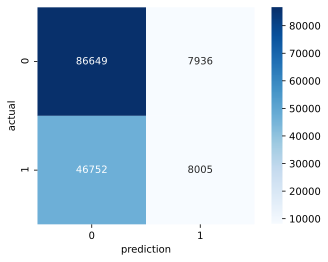

In [39]:
X_test = scaler.transform(combined_df_test[['STAT_CAUSE_DESCR_Campfire', 
                    'STAT_CAUSE_DESCR_Children', 'STAT_CAUSE_DESCR_Debris Burning',
                     'STAT_CAUSE_DESCR_Equipment Use', 'STAT_CAUSE_DESCR_Fireworks',
                     'STAT_CAUSE_DESCR_Lightning', 'STAT_CAUSE_DESCR_Miscellaneous', 
                     'STAT_CAUSE_DESCR_Missing/Undefined', 'STAT_CAUSE_DESCR_Powerline',             
                     'STAT_CAUSE_DESCR_Railroad', 'STAT_CAUSE_DESCR_Smoking',
                      'STAT_CAUSE_DESCR_Structure']])


preds = lm_3.predict(X_test)

conf_matrix = confusion_matrix(combined_df_test['FIRE_SIZE_CLASS_BIN'], preds)
sns.heatmap(conf_matrix, cmap=plt.cm.Blues, annot=True, square=True, fmt='d')
plt.xlabel('prediction')
plt.ylabel('actual');

In [17]:
lm_3.score(X_test, combined_df_test['FIRE_SIZE_CLASS_BIN'])

0.6338069665599765

In [18]:
f1_score(combined_df_test['FIRE_SIZE_CLASS_BIN'], preds)

0.22645619395173838

In [19]:
combined_df_test['FIRE_SIZE_CLASS_BIN'].value_counts()

0    94585
1    54757
Name: FIRE_SIZE_CLASS_BIN, dtype: int64

In [20]:
combined_df_test['proba_lrg'] = lm_3.predict_proba(combined_df_test[['STAT_CAUSE_DESCR_Campfire', 
                    'STAT_CAUSE_DESCR_Children', 'STAT_CAUSE_DESCR_Debris Burning',
                     'STAT_CAUSE_DESCR_Equipment Use', 'STAT_CAUSE_DESCR_Fireworks',
                     'STAT_CAUSE_DESCR_Lightning', 'STAT_CAUSE_DESCR_Miscellaneous', 
                     'STAT_CAUSE_DESCR_Missing/Undefined', 'STAT_CAUSE_DESCR_Powerline',             
                     'STAT_CAUSE_DESCR_Railroad', 'STAT_CAUSE_DESCR_Smoking',
                      'STAT_CAUSE_DESCR_Structure']])[:, 1]

fpr, tpr, thresholds = roc_curve(combined_df_test['FIRE_SIZE_CLASS_BIN'],
                                 combined_df_test['proba_lrg'])

def plot_roc(true, probas):
    auc = roc_auc_score(true, probas)

    plt.plot(fpr, tpr, marker='o')
    plt.xlabel('1 - Specificity (FPR)')
    plt.ylabel('Sensitivity (TPR)');
    plt.title(f"Area Under the ROC Curve: {round(auc, 3)}");

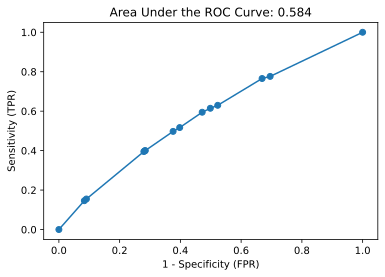

In [21]:
plot_roc(combined_df_test['FIRE_SIZE_CLASS_BIN'], lm_3.predict_proba(X_test)[:, 1])

In [41]:
scaler = StandardScaler()
X_train = scaler.fit_transform(combined_df[['REGION_None', 
                    'REGION_Northeast', 'REGION_Northern Rockies',
                     'REGION_Northwest', 'REGION_Ohio Valley',
                     'REGION_South', 'REGION_Southeast', 
                     'REGION_Southwest', 'REGION_Upper Midwest',             
                     'REGION_West']])
y_train = combined_df['FIRE_SIZE_CLASS_BIN']

    

In [42]:
lm_4 = LogisticRegression()
lm_4.fit(X_train, y_train)
lm_4.score(X_train, y_train)

0.634330319552302

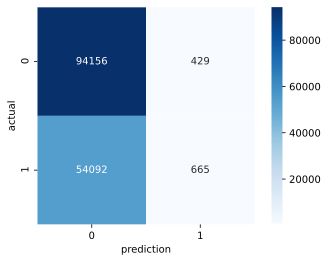

In [43]:
X_test = scaler.transform(combined_df_test[[ 'REGION_None', 
                    'REGION_Northeast', 'REGION_Northern Rockies',
                     'REGION_Northwest', 'REGION_Ohio Valley',
                     'REGION_South', 'REGION_Southeast', 
                     'REGION_Southwest', 'REGION_Upper Midwest',             
                     'REGION_West']])


preds = lm_4.predict(X_test)

conf_matrix = confusion_matrix(combined_df_test['FIRE_SIZE_CLASS_BIN'], preds)
sns.heatmap(conf_matrix, cmap=plt.cm.Blues, annot=True, square=True, fmt='d')
plt.xlabel('prediction')
plt.ylabel('actual');

In [58]:
scaler = StandardScaler()
X_train = scaler.fit_transform(combined_df[['REGION_None', 
                    'REGION_Northeast', 'REGION_Northern Rockies',
                     'REGION_Northwest', 'REGION_Ohio Valley',
                     'REGION_South', 'REGION_Southeast', 
                     'REGION_Southwest', 'REGION_Upper Midwest',             
                     'REGION_West', 'STAT_CAUSE_DESCR_Campfire', 
                    'STAT_CAUSE_DESCR_Children', 'STAT_CAUSE_DESCR_Debris Burning',
                     'STAT_CAUSE_DESCR_Equipment Use', 'STAT_CAUSE_DESCR_Fireworks',
                     'STAT_CAUSE_DESCR_Lightning', 'STAT_CAUSE_DESCR_Miscellaneous', 
                     'STAT_CAUSE_DESCR_Missing/Undefined', 'STAT_CAUSE_DESCR_Powerline',             
                     'STAT_CAUSE_DESCR_Railroad', 'STAT_CAUSE_DESCR_Smoking',
                      'STAT_CAUSE_DESCR_Structure']])
y_train = combined_df['FIRE_SIZE_CLASS_BIN']

In [59]:
lm_5 = LogisticRegressionCV()
lm_5.fit(X_train, y_train)
lm_5.score(X_train, y_train)

0.6383496242678287

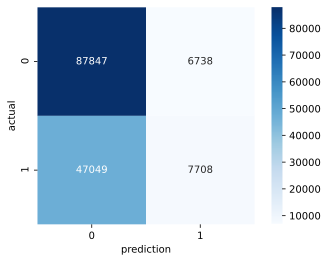

In [60]:
X_test = scaler.transform(combined_df_test[[ 'REGION_None', 
                    'REGION_Northeast', 'REGION_Northern Rockies',
                     'REGION_Northwest', 'REGION_Ohio Valley',
                     'REGION_South', 'REGION_Southeast', 
                     'REGION_Southwest', 'REGION_Upper Midwest',             
                     'REGION_West', 'STAT_CAUSE_DESCR_Campfire', 
                    'STAT_CAUSE_DESCR_Children', 'STAT_CAUSE_DESCR_Debris Burning',
                     'STAT_CAUSE_DESCR_Equipment Use', 'STAT_CAUSE_DESCR_Fireworks',
                     'STAT_CAUSE_DESCR_Lightning', 'STAT_CAUSE_DESCR_Miscellaneous', 
                     'STAT_CAUSE_DESCR_Missing/Undefined', 'STAT_CAUSE_DESCR_Powerline',             
                     'STAT_CAUSE_DESCR_Railroad', 'STAT_CAUSE_DESCR_Smoking',
                      'STAT_CAUSE_DESCR_Structure']])


preds = lm_5.predict(X_test)

conf_matrix = confusion_matrix(combined_df_test['FIRE_SIZE_CLASS_BIN'], preds)
sns.heatmap(conf_matrix, cmap=plt.cm.Blues, annot=True, square=True, fmt='d')
plt.xlabel('prediction')
plt.ylabel('actual');

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score

X_train = combined_df[['STAT_CAUSE_DESCR_Campfire', 
                    'STAT_CAUSE_DESCR_Children', 'STAT_CAUSE_DESCR_Debris Burning',
                     'STAT_CAUSE_DESCR_Equipment Use', 'STAT_CAUSE_DESCR_Fireworks',
                     'STAT_CAUSE_DESCR_Lightning', 'STAT_CAUSE_DESCR_Miscellaneous', 
                     'STAT_CAUSE_DESCR_Missing/Undefined', 'STAT_CAUSE_DESCR_Powerline',             
                     'STAT_CAUSE_DESCR_Railroad', 'STAT_CAUSE_DESCR_Smoking',
                      'STAT_CAUSE_DESCR_Structure']]

y_train = combined_df['FIRE_SIZE_CLASS_BIN']


knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
print(scores)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
print(scores)

### Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
# either Bernoulli or Multinomial
nb = NB()
nb.fit(X_train, y_train)
nb.score(X_train, y_train)

### Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

def quick_test(model, X, y):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
    model.fit(xtrain, ytrain)
    return model.score(xtest, ytest)

def quick_test_afew_times(model, X, y, n=10):
    return np.mean([quick_test(model, X, y) for j in range(n)])

In [13]:
X_train = combined_df[['REGION_None', 
                    'REGION_Northeast', 'REGION_Northern Rockies',
                     'REGION_Northwest', 'REGION_Ohio Valley',
                     'REGION_South', 'REGION_Southeast', 
                     'REGION_Southwest', 'REGION_Upper Midwest',             
                     'REGION_West', 'STAT_CAUSE_DESCR_Campfire', 
                    'STAT_CAUSE_DESCR_Children', 'STAT_CAUSE_DESCR_Debris Burning',
                     'STAT_CAUSE_DESCR_Equipment Use', 'STAT_CAUSE_DESCR_Fireworks',
                     'STAT_CAUSE_DESCR_Lightning', 'STAT_CAUSE_DESCR_Miscellaneous', 
                     'STAT_CAUSE_DESCR_Missing/Undefined', 'STAT_CAUSE_DESCR_Powerline',             
                     'STAT_CAUSE_DESCR_Railroad', 'STAT_CAUSE_DESCR_Smoking',
                      'STAT_CAUSE_DESCR_Structure', 'DISCOVERY_DOY', 'FIRE_YEAR']]

y_train = combined_df['FIRE_SIZE_CLASS_BIN']


In [14]:
randomforest = RandomForestClassifier(n_estimators=100)
quick_test_afew_times(randomforest, X_train, y_train)

0.616428679043139

In [15]:
X_test = (combined_df_test[[ 'REGION_None', 
                    'REGION_Northeast', 'REGION_Northern Rockies',
                     'REGION_Northwest', 'REGION_Ohio Valley',
                     'REGION_South', 'REGION_Southeast', 
                     'REGION_Southwest', 'REGION_Upper Midwest',             
                     'REGION_West', 'STAT_CAUSE_DESCR_Campfire', 
                    'STAT_CAUSE_DESCR_Children', 'STAT_CAUSE_DESCR_Debris Burning',
                     'STAT_CAUSE_DESCR_Equipment Use', 'STAT_CAUSE_DESCR_Fireworks',
                     'STAT_CAUSE_DESCR_Lightning', 'STAT_CAUSE_DESCR_Miscellaneous', 
                     'STAT_CAUSE_DESCR_Missing/Undefined', 'STAT_CAUSE_DESCR_Powerline',             
                     'STAT_CAUSE_DESCR_Railroad', 'STAT_CAUSE_DESCR_Smoking',
                      'STAT_CAUSE_DESCR_Structure', 'DISCOVERY_DOY', 'FIRE_YEAR']])


preds = randomforest.predict(X_test)

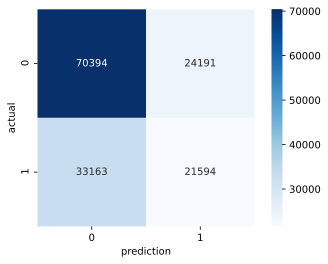

In [16]:
conf_matrix = confusion_matrix(combined_df_test['FIRE_SIZE_CLASS_BIN'], preds)
sns.heatmap(conf_matrix, cmap=plt.cm.Blues, annot=True, square=True, fmt='d')
plt.xlabel('prediction')
plt.ylabel('actual');

In [55]:
def visualize(X, y, bdry='diag'):
    c = cm.rainbow(np.linspace(0, 1, 2))
    plt.scatter([i[0] for i in X], [i[1] for i in X], color=[c[i] for i in y], alpha=.5)
    
    #Plot the true decision boundary
    if bdry == 'diag':
        plt.plot([0, 1], [0, 1], 'k--')
    elif bdry == 'quadrant':
        plt.plot([0, 1], [0.5, 0.5], 'k--')
        plt.plot([0.5, 0.5], [0, 1], 'k--')
        
    plt.grid(True)
    

In [56]:
randomforest.fit(X_train, y_train)

grid = np.mgrid[0:1.02:0.02, 0:1.02:0.02].reshape(2,-1).T
visualize(grid, randomforest.predict(grid))

ValueError: Number of features of the model must match the input. Model n_features is 24 and input n_features is 2 

In [ ]:
# Need to do
# Precision Recall Curve
# Correlation 